## Multi-Class Intrusion type detection : Intrusion type detection for attack type increases system complexity

### 전처리

In [1]:
import numpy as np
import pandas as pd

from sklearn import datasets, metrics, tree, svm, neighbors
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neighbors import NearestCentroid

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [61]:
# , usecols = ['IPV4_SRC_ADDR','L4_SRC_PORT','IPV4_DST_ADDR','L4_DST_PORT','PROTOCOL','L7_PROTO','IN_BYTES','IN_PKTS','OUT_BYTES','OUT_PKTS','TCP_FLAGS','CLIENT_TCP_FLAGS','SERVER_TCP_FLAGS','FLOW_DURATION_MILLISECONDS','DURATION_IN','MIN_TTL','MAX_TTL','LONGEST_FLOW_PKT','SHORTEST_FLOW_PKT','MIN_IP_PKT_LEN','MAX_IP_PKT_LEN','SRC_TO_DST_SECOND_BYTES','DST_TO_SRC_SECOND_BYTES','SRC_TO_DST_AVG_THROUGHPUT','DST_TO_SRC_AVG_THROUGHPUT','NUM_PKTS_UP_TO_128_BYTES','TCP_WIN_MAX_IN','TCP_WIN_MAX_OUT','ICMP_TYPE','ICMP_IPV4_TYPE','DNS_QUERY_ID','DNS_QUERY_TYPE','DNS_TTL_ANSWER','FTP_COMMAND_RET_CODE','Label','Attack']
df = pd.read_csv("NF-UQ-NIDS-v2.csv",index_col=False, nrows=1)
cols = df.columns
df1 = pd.read_csv("NF-UQ-NIDS-v2.csv", header=None, names=cols, skiprows=1, nrows=200000, index_col=False)
df2 = pd.read_csv("NF-UQ-NIDS-v2.csv", header=None, names=cols, skiprows=200001, nrows=200000, index_col=False)
df3 = pd.concat([df1, df2], ignore_index = True)

# df = pd.read_csv("NF-UQ-NIDS-v2_sample.csv",chunksize=1000000)

In [62]:
df1.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack,Dataset
0,192.168.100.148,65389,192.168.100.7,80,6,7.0,420,3,0,0,...,0,35840,140,0,0,0,0.0,1,DoS,NF-BoT-IoT-v2
1,192.168.100.148,11154,192.168.100.5,80,6,7.0,280,2,40,1,...,0,0,0,0,0,0,0.0,1,DoS,NF-BoT-IoT-v2
2,192.168.1.31,42062,192.168.1.79,1041,6,0.0,44,1,40,1,...,0,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2
3,192.168.1.34,46849,192.168.1.79,9110,6,0.0,44,1,40,1,...,0,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2
4,192.168.1.30,50360,192.168.1.152,1084,6,0.0,44,1,40,1,...,0,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2


In [63]:
X1 = df1.drop(['Attack','Label','Dataset','IPV4_DST_ADDR','IPV4_SRC_ADDR'], axis=1)
Y1 = df1["Attack"]

X1_test = df2.drop(['Attack','Label','Dataset','IPV4_DST_ADDR','IPV4_SRC_ADDR'], axis=1)
Y1_test = df2["Attack"]

In [64]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit(df3['Attack'])

multilbl = LE.transform(Y1)
Y1 = pd.Series(multilbl)

multilbl = LE.transform(Y1_test)
Y1_test = pd.Series(multilbl)

In [65]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

X1_object = X1.select_dtypes("object")
X1_int = X1.select_dtypes(exclude = "object")

X1_columns = X1_int.columns

imputer.fit(X1_int)
X1_int = imputer.transform(X1_int)
X1_int = pd.DataFrame(X1_int)
X1_int.columns = X1_columns

X1_object = X1_object.fillna("unknown")
X1 = X1_object.join(X1_int)

In [66]:
X1_object = X1_test.select_dtypes("object")
X1_int = X1_test.select_dtypes(exclude = "object")

X1_columns = X1_int.columns

imputer.fit(X1_int)
X1_int = imputer.transform(X1_int)
X1_int = pd.DataFrame(X1_int)
X1_int.columns = X1_columns

X1_object = X1_object.fillna("unknown")
X1_test = X1_object.join(X1_int)

In [67]:
X_train_1 = X1
X_test_1 =  X1_test
y_train_1 = Y1
y_test_1 = Y1_test

In [68]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
# store the columns
cols = X_train_1.columns

# transform the data
X_train_scaled_1 = scaler.fit_transform(X_train_1)
X_test_scaled_1 = scaler.transform(X_test_1)

X_train_scaled_1 = pd.DataFrame(X_train_scaled_1, columns = cols)
X_test_scaled_1 = pd.DataFrame(X_test_scaled_1, columns = cols)

In [69]:
X_train_scaled_1

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE
0,0.997772,0.001221,0.019841,0.028571,0.000012,0.000018,0.000000e+00,0.000000,0.008969,0.008969,...,0.000000,0.000000,0.007813,0.000000,0.54902,0.54902,0.000000,0.000000,0.000000e+00,0.0
1,0.170199,0.001221,0.019841,0.028571,0.000008,0.000009,3.236493e-07,0.000012,0.098655,0.008969,...,0.000000,0.000000,0.007813,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000e+00,0.0
2,0.641825,0.015885,0.019841,0.000000,0.000001,0.000000,3.236493e-07,0.000012,0.098655,0.008969,...,0.000000,0.000000,0.015625,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000e+00,0.0
3,0.714870,0.139010,0.019841,0.000000,0.000001,0.000000,3.236493e-07,0.000012,0.098655,0.008969,...,0.000000,0.000000,0.015625,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000e+00,0.0
4,0.768444,0.016541,0.019841,0.000000,0.000001,0.000000,3.236493e-07,0.000012,0.098655,0.008969,...,0.000000,0.000000,0.015625,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.900465,0.001221,0.019841,0.028571,0.000006,0.000028,9.062179e-07,0.000024,0.085202,0.085202,...,0.000000,0.000000,0.445563,0.409659,0.00000,0.00000,0.000000,0.000000,0.000000e+00,0.0
199996,0.445884,0.000809,0.063492,0.021273,0.000006,0.000009,2.233180e-06,0.000024,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.154191,0.003922,6.985003e-09,0.0
199997,0.001221,0.707195,0.019841,0.028571,0.000013,0.000074,0.000000e+00,0.000000,0.076233,0.076233,...,0.000000,0.000000,0.003494,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000e+00,0.0
199998,0.923140,0.051713,0.019841,0.000000,0.000045,0.000083,1.515488e-05,0.000085,0.134529,0.134529,...,0.000029,0.000012,0.125002,0.976577,0.00000,0.00000,0.000000,0.000000,0.000000e+00,0.0


In [70]:
X_test_scaled_1

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE
0,0.796231,0.201755,0.019841,0.000000,0.000001,0.000000,3.236493e-07,0.000012,0.098655,0.008969,...,0.000000,0.000000,0.062501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0
1,0.359899,0.000381,0.019841,0.000000,0.004789,0.001303,2.011480e-05,0.000460,0.121076,0.121076,...,0.000000,0.001312,0.249989,0.249989,0.372564,0.372549,0.000000,0.000000,0.000000e+00,0.0
2,0.890501,0.051713,0.019841,0.000000,0.000045,0.000083,1.515488e-05,0.000085,0.995516,0.995516,...,0.000029,0.000012,0.125002,0.976577,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0
3,0.932448,0.001221,0.019841,0.028571,0.000008,0.000009,0.000000e+00,0.000000,0.008969,0.008969,...,0.000000,0.000000,0.007813,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0
4,0.824704,0.123293,0.019841,0.537551,0.000015,0.000037,2.759110e-06,0.000060,0.982063,0.982063,...,0.000000,0.000000,0.125002,0.410208,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.522698,0.001221,0.063492,0.767347,0.000004,0.000037,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0
199996,0.782208,0.001221,0.063492,0.767347,0.000002,0.000009,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0
199997,0.732906,0.737301,0.019841,0.000000,0.000001,0.000000,0.000000e+00,0.000000,0.008969,0.008969,...,0.000000,0.000000,0.062501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0
199998,0.768490,0.001221,0.019841,0.028571,0.000008,0.000009,0.000000e+00,0.000000,0.008969,0.008969,...,0.000000,0.000000,0.007813,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0


### 모델 구축

In [71]:
SEED = 42

# Decision Tree Model
dtc = DecisionTreeClassifier()

# SVC MODEL

from sklearn.svm import SVC
svc = SVC(random_state = SEED)

# LOGISTIC REGRESSION MODEL
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=50000)

# GAUSSIAN NAIVE BAYES
gnb = GaussianNB()

# BERNOULLI NAIVE BAYES
bnb = BernoulliNB()

# Train RandomForestClassifier
rfe = RandomForestClassifier(max_depth=6)

# Train XGBOOST Classifier
from xgboost import XGBClassifier
xgbc = XGBClassifier(eval_metric="logloss", random_state=SEED)

# Train LightGBM Classifier
from lightgbm import LGBMClassifier
lgbmc = LGBMClassifier(random_state=SEED)

# Train Gradient-Boosting Classifier
grb = GradientBoostingClassifier(learning_rate=1.1)

In [72]:
models_1 = {}
# models_1['SVC']= svc
# models_1['LogisticRegression']= lr
# models_1['DecisionTreeClassifier']= dtc
# models_1['Gaussian Naive Bayes Classifier']= gnb
# models_1['Bernoulli Naive Bayes Classifier']= bnb
# models_1['Gradient Boosting Classifier']= grb
# models_1['Random Forest Classifier']= rfe
models_1['XGBoost Classifier']= xgbc
# models_1['LightGBM Classifier']= lgbmc
preds_1={}
modelAcc_1={}
for name in models_1:
    models_1[name].fit(X_train_scaled_1, y_train_1)
    preds_1[name] = models_1[name].predict(X_test_scaled_1)
    modelAcc_1[name] = accuracy_score(y_test_1, preds_1[name])
    # cfm_plot = plot_confusion_matrix(models[name], X_train_scaled, y_train)
    # cfm_plot.savefig("cfm_"+name+".png")
print("Predictions complete.")

Predictions complete.


In [73]:
print('*************** Accuracy ***************')
for name in models_1:
    print(f'{name}: {modelAcc_1[name]}')

*************** Accuracy ***************
XGBoost Classifier: 0.978725


In [74]:
from sklearn.metrics import precision_recall_fscore_support

evaluation_results={}
# 각 모델에 대해 예측을 수행하고 평가 지표를 계산
for name in models_1:
    # 정확도 계산

    # precision, recall, f1-score 계산
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test_1, preds_1[name], average='weighted', zero_division=1.0)

    # 결과를 딕셔너리에 저장
    evaluation_results[name] = {
        'Accuracy': modelAcc_1[name],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

# 결과를 데이터 프레임으로 변환
df_results = pd.DataFrame(evaluation_results).T

# 결과 출력
print(df_results)

                    Accuracy  Precision    Recall  F1 Score
XGBoost Classifier  0.978725   0.978271  0.978725  0.977612


In [75]:
from sklearn.metrics import confusion_matrix, classification_report
def line(name,sym="*"):
    return sym*(25-len(name)//2)
for name in models_1:
    print(line(name), name, 'Model Testing', line(name))
    print(classification_report(y_test_1, preds_1[name], zero_division=1.0))

**************** XGBoost Classifier Model Testing ****************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       1.00      0.82      0.90        49
           2       0.98      0.99      0.98     66528
           3       1.00      1.00      1.00       353
           4       1.00      0.98      0.99       315
           5       0.99      0.99      0.99     57116
           6       0.98      0.99      0.99     47009
           7       0.69      0.80      0.74        87
           8       0.71      0.65      0.68        60
           9       0.85      0.72      0.78        46
          10       0.82      0.03      0.05       325
          11       0.94      0.80      0.86      6849
          12       0.50      0.40      0.44         5
          13       0.50      0.17      0.25         6
          15       0.89      0.79      0.84      1796
          16       1.00      0.24      0.38        21
          17  

**************** XGBoost Classifier Model Testing ****************


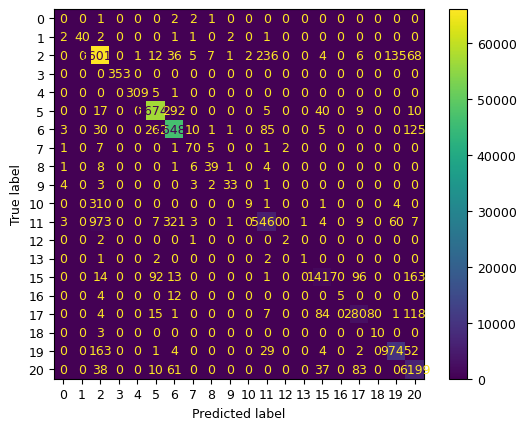

In [76]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name in models_1:
    print(line(name), name, 'Model Testing', line(name))
    plt.rc('font', size=9)  # 추가 코드 - 폰트 크기를 줄입니다
    ConfusionMatrixDisplay.from_predictions(y_test_1, preds_1[name])
    plt.show()

In [77]:
feature_imp = pd.DataFrame({'Importance':models_1['XGBoost Classifier'].feature_importances_,'feature':X_train_scaled_1.columns})
feature_imp = feature_imp.sort_values('Importance',ascending=False).set_index('feature')

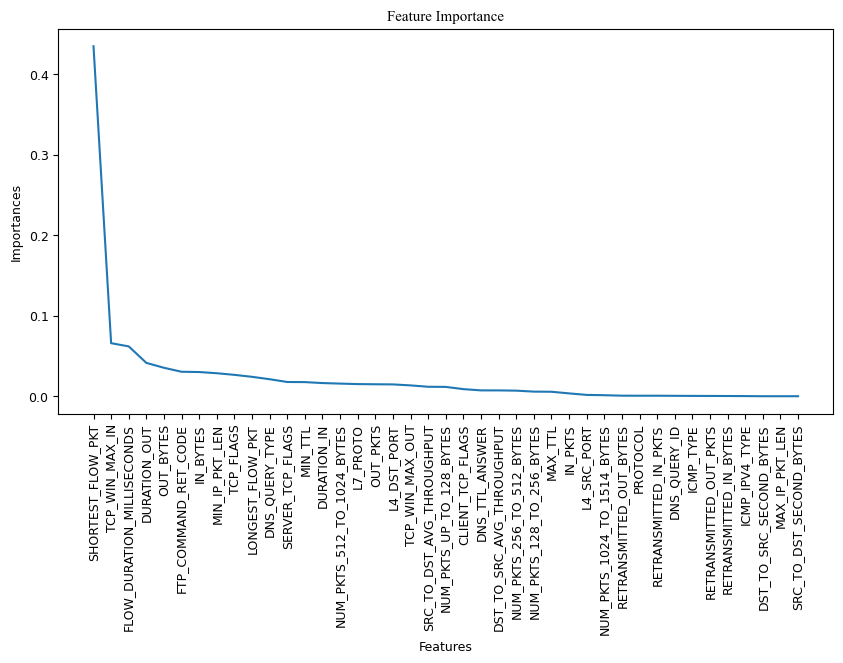

In [78]:
plt.figure(figsize = (10, 5))
plt.title("Feature Importance", fontname="Times New Roman")
plt.ylabel("Importances")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.plot(feature_imp)
plt.savefig('feature_importance.jpg', bbox_inches='tight' , dpi=900)

### lightgbm

In [16]:
import lightgbm
print(lightgbm.__version__)

4.3.0


In [11]:
from lightgbm import LGBMClassifier

SEED = 42
name = "LGBMClassifier"

lgbmc = LGBMClassifier(random_state=SEED)
lgbmc.fit(X_train_scaled_1, y_train_1)
lgbmc_predict = lgbmc.predict(X_test_scaled_1)

print(line(name), name, 'Model Testing', line(name))
print(confusion_matrix(y_test_1, preds_1[name]))
print(line(name,'-'))
print(classification_report(y_test_1, preds_1[name]))

: 

Decision Tree

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train_scaled_1, y_train_1)
# dtree_predictions = dtree_model.predict(X_test_scaled_1)
# # creating a confusion matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test_1, dtree_predictions)

SVM

In [ ]:
# from sklearn.svm import SVC
# svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train_scaled_1, y_train_1)
# svm_predictions = svm_model_linear.predict(X_test_scaled_1)

# # model accuracy for X_test
# accuracy = svm_model_linear.score(X_test_scaled_1, y_test_1)
# # creating a confusion matrix
# cm = confusion_matrix(y_test_1, svm_predictions)

In [ ]:
# # SVM for Multiclass Predictions
# accuracy

KNN

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)

# # accuracy on X_test
# accuracy = knn.score(X_test, y_test)
# print accuracy

# # creating a confusion matrix
# knn_predictions = knn.predict(X_test)
# cm = confusion_matrix(y_test, knn_predictions)

Naive Bayes

In [ ]:
# from sklearn.naive_bayes import GaussianNB
# gnb = GaussianNB().fit(X_train, y_train)
# gnb_predictions = gnb.predict(X_test)

# # accuracy on X_test
# accuracy = gnb.score(X_test, y_test)
# print accuracy

# # creating a confusion matrix
# cm = confusion_matrix(y_test, gnb_predictions)

In [ ]:
# from sklearn.model_selection import cross_val_score
# models = {}
# models['SVC']= svc
# models['LogisticRegression']= lr
# models['DecisionTreeClassifier']= dtc
# models['Gaussian Naive Bayes Classifier']= gnb
# models['Bernoulli Naive Bayes Classifier']= bnb
# models['Gradient Boosting Classifier']= grb
# models['Random Forest Classifier']= rfe
# models['XGBoost Classifier']= xgbc
# models['LightGBM Classifier']= lgbmc
# scores = {}
# for name in models:
#   scores[name]={}
#   for scorer in ['precision','recall']:
#     scores[name][scorer] = cross_val_score(models[name], X_train_scaled_1, y_train_1, cv=2, scoring=scorer)

In [ ]:
# def line(name):
#   return '*'*(25-len(name)//2)

# for name in models:
#   print(line(name), name, 'Model Validation', line(name))

#   for scorer in ['precision','recall']:
#     mean = round(np.mean(scores[name][scorer])*100,2)
#     stdev = round(np.std(scores[name][scorer])*100,2)
#     print ("Mean {}:".format(scorer),"\n", mean,"%", "+-",stdev)
#     print()

In [ ]:
# for name in models:
#     for scorer in ['precision','recall']:
#         scores[name][scorer] = scores[name][scorer].mean()
# scores=pd.DataFrame(scores).swapaxes("index", "columns")*100
# scores.plot(kind = "bar",  ylim=[80,100], figsize=(24,6), rot=0)
# plt.savefig('precision-recall_1.png', bbox_inches='tight')

In [ ]:
# models = {}
# models['SVC']= svc
# models['LogisticRegression']= lr
# models['DecisionTreeClassifier']= dtc
# models['Gaussian Naive Bayes Classifier']= gnb
# models['Bernoulli Naive Bayes Classifier']= bnb
# models['Gradient Boosting Classifier']= grb
# models['Random Forest Classifier']= rfe
# models['XGBoost Classifier']= xgbc
# models['LightGBM Classifier']= lgbmc
# preds={}
# for name in models:
#     models[name].fit(X_train_scaled, y_train)
#     preds[name] = models[name].predict(X_test_scaled)
# print("Predictions complete.")

In [ ]:
# f1s = {}
# for name in models:
#     f1s[name]=f1_score(y_test, preds[name])
# f1s=pd.DataFrame(f1s.values(),index=f1s.keys(),columns=["F1-score"])*100
# f1s.plot(kind = "bar",  ylim=[80,100], figsize=(16,6), rot=0)
# plt.savefig('f1-score.png', bbox_inches='tight')

## Deep Learning Approach for MClass Detection

In [ ]:
import pandas
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [ ]:
# estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=80, verbose=1)

In [ ]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = MinMaxScaler()
# # store the columns
# cols = X1.columns
# # transform the data
# X1_dl = scaler.fit_transform(X1)
# X1_dl = pd.DataFrame(X1_dl, columns = cols)

# kfold = KFold(n_splits=2, shuffle=True)
# results = cross_val_score(estimator, X1_dl, Y1, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
model = Sequential()
model.add(Dense(40, input_dim=43, activation='relu'))
model.add(Dense(35, activation = 'relu'))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(25, activation = 'relu'))
model.add(Dense(21, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
# store the columns
cols = X1.columns
# transform the data
X1_dl = scaler.fit_transform(X1)
X1_dl = pd.DataFrame(X1_dl, columns = cols)

from tensorflow.keras.utils import to_categorical
y_cat = to_categorical(Y1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train_dl, x_test_dl, y_train_dl, y_test_dl = train_test_split(X1_dl, y_cat, test_size=0.2)

In [ ]:
k = model.fit(x_train_dl ,y_train_dl, verbose=1, epochs=100, batch_size=128)

# kfold = KFold(n_splits=2, shuffle=True)
# results = cross_val_score(estimator, X1_dl, Y1, cv=kfold)

In [ ]:
mean = sum(k.history['accuracy']) / len(k.history['accuracy'])
variance = sum([((x - mean) ** 2) for x in k.history['accuracy']]) / len(k.history['accuracy'])
res = variance ** 0.5
print("Baseline: %.2f%% (%.2f%%)" % (mean*100, res*100))

In [ ]:
df1['Attack'].unique()

In [ ]:
# y_pred_class = mod.predict(x_test_dl)
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_test_dl)
y_pred_class = y_pred.argmax(axis=-1)
y_test_class = np.argmax(y_test_dl, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_test_class, y_pred_class))

In [ ]:
set(y_test_class) - set(y_pred_class)

In [ ]:
from matplotlib import pyplot
pyplot.plot(k.history['accuracy'])
pyplot.savefig('DL_NN_Accuracy_EpochVsAccuracy.jpg',dpi=900)
pyplot.show()

In [ ]:
import subprocess
from ast import literal_eval

def run(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    out, err = process.communicate()
    print(out.decode('utf-8').strip())

In [ ]:
print('# CPU')
run('cat /proc/cpuinfo | egrep -m 1 "^model name"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu MHz"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu cores"')

In [ ]:
print('# RAM')
run('cat /proc/meminfo | egrep "^MemTotal"')

In [ ]:
print('# OS')
run('uname -a')

In [ ]:
print('# GPU')
run('lspci | grep VGA')